# QAOA Weighted Maxcut

MaxCut problem — given a graph, find a way to divide it into two groups, such that the edges going between the two groups have the biggest possible weight. <br>
The code below is the generalised solution for weighted maxcut by introducing minor changes in [the code for unweighted graph](https://lucaman99.github.io/new_blog/2020/mar16.html) by [Jack Ceroni](https://lucaman99.github.io/)

### Cost function

The MAXCUT objective is to minimize the cost function: $C \ = \ \displaystyle\sum_{a, \ b} \ \frac{1}{2} w_{ab} (c_a c_b \ - \ 1) \ \ \ \ \ (a, \ b) \ \in \ E$


### Constructing the Hamiltonian

The Hamiltonian can be constructed by mapping binary variables $c_i$ onto the eigenvalues of $Z$. The above minimization problem has the following Hamiltonian:

$\hat{H}_C \ = \ \displaystyle\sum_{a, \ b} \ \frac{1}{2} w_{ab} (Z_a \ \otimes \ Z_b \ - \ \mathbb{I}) \ \ \ \ \ (a, \ b) \ \in \ E$

### Choosing the Mixer
We choose our mixer:

$\hat{H}_M \ = \ \displaystyle\sum_{n} X_{n}$

Where n sums over all qubits. This does not commute with $\hat{H}_C$.

### Constructing QAOA circuit

The full QAOA circuit:

$|\psi{(\mathbb{\alpha},\mathbb{\gamma})}> =  e^{-i\alpha_p \hat{H}_M}e^{-i\gamma_p \hat{H}_C}\cdots e^{-i\alpha_1 \hat{H}_M}e^{-i\gamma_1 \hat{H}_C} H^{\otimes n} |0>$

Need to implement cost operator $e^{-i\gamma_p \hat{H}_C}$ and mixer operator $e^{-i\alpha_p \hat{H}_M}$

### Graph construction:
The Graph is constructed using the Python Library: networkx. A custom class called "Edge" is created to store start node, end node and weight of the edge.<br> 
A list called "set_edge" store all the edges of the Graph.<br>


{('0', '1'): Text(0.43486257883570945, -0.4624747766831333, '5'),
 ('0', '2'): Text(0.5465698239162602, -0.2749351141854558, '1'),
 ('1', '2'): Text(0.33121306484335983, -0.06677020261182895, '7'),
 ('1', '3'): Text(-0.04656982391626063, -0.02125908379326112, '4'),
 ('2', '3'): Text(0.06513742116429017, 0.1662805787044164, '2'),
 ('3', '4'): Text(-0.6563227337976651, 0.40209004674020904, '3')}

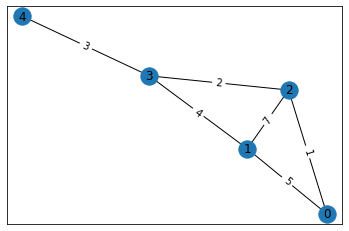

In [1]:
import networkx as nx
from matplotlib import pyplot as plt

class Graph:
    def __init__(self, edges_set):
        self.edges_set = edges_set
        self.node_set = []
        for i in edges_set:
            if (i.start_node not in self.node_set):
                self.node_set.append(i.start_node)
            if (i.end_node not in self.node_set):
                self.node_set.append(i.end_node)

class Edge:
    def __init__(self, start_node, end_node, edge_weight):
        self.start_node = start_node
        self.end_node = end_node
        self.edge_weight = edge_weight

set_edges = [Edge(0, 1, 5), Edge(0, 2, 1), Edge(1, 2, 7), Edge(1, 3, 4), Edge(2, 3, 2), Edge(3, 4, 3)]

G = nx.Graph()

for z in set_edges:
    G.add_edge(str(z.start_node), str(z.end_node), weight = z.edge_weight)


pos=nx.spring_layout(G) 
nx.draw_networkx(G,pos)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

### Importing necessary libraries, specifying all of the initial parameters, and defining a function that gives us our initial state, which will just be an even superposition of all basis states.

In [2]:
import cirq
import numpy as np
import math
from matplotlib import pyplot as plt
import random
from scipy.optimize import minimize

# Defines the list of qubits

num = 5
depth = 4
rep = 1000
qubits = [cirq.GridQubit(0, i) for i in range(0, num)]


# Defines the initialization

def initialization(qubits):
    for i in qubits:
        yield cirq.H.on(i)

### Function for Cost and Mixer layers:
 cost operator $e^{-i\gamma_p \hat{H}_C}$ and mixer operator $e^{-i\alpha_p \hat{H}_M}$

In [3]:
# Defines the cost unitary

def cost_unitary(qubits, gamma):
    for i in set_edges:
        yield cirq.ZZPowGate(exponent=-1*gamma*i.edge_weight/math.pi).on(qubits[i.start_node], qubits[i.end_node])

# Defines the mixer unitary

def mixer_unitary(qubits, alpha):
    for i in range(0, len(qubits)):
        yield cirq.XPowGate(exponent=-1*alpha/math.pi).on(qubits[i])

### Function to create and execute the QAOA circuit:


In [4]:
# Executes the circuit

def create_circuit(params):

    gamma = [params[0], params[2], params[4], params[6]]
    alpha = [params[1], params[3], params[5], params[7]]

    circuit = cirq.Circuit()
    circuit.append(initialization(qubits))
    for i in range(0, depth):
        circuit.append(cost_unitary(qubits, gamma[i]))
        circuit.append(mixer_unitary(qubits, alpha[i]))
    circuit.append(cirq.measure(*qubits, key='x'))
    #print(circuit)

    simulator = cirq.Simulator()
    results = simulator.run(circuit, repetitions=rep)
    results = str(results)[2:].split(", ")
    new_res = []
    for i in range(0, rep):
        hold = []
        for j in range(0, num):
            hold.append(int(results[j][i]))
        new_res.append(hold)

    return new_res

### The cost function:
$C \ = \ \displaystyle\sum_{a, \ b} \ \frac{1}{2} w_{ab} (c_a c_b \ - \ 1) \ \ \ \ \ (a, \ b) \ \in \ E$<br>
Since the values that are outputted from the circuit are 0s and 1s, instead of the desired 1 and −1 values. Thus, in the place of $c_n$, we defined a function $f(x) \ = \ 1 \ - \ 2x$, which maps 0 to 1 and 1 to −1:

In [5]:
# Defines the cost function

def cost_function(params):

    av = create_circuit(params)
    total_cost = 0
    for i in range(0, len(av)):
        for j in set_edges:
            total_cost += j.edge_weight*0.5*( ( (1 - 2*av[i][j.start_node]) * (1 - 2*av[i][j.end_node]) ) - 1)
    total_cost = float(total_cost)/rep

    #print("Cost: "+str(total_cost))

    return total_cost

### Function for Optimization:
This function outputs the expected value of the cost function (calculate the average cost over 1000 repetitions of the algorithm). Finally, we can define a classical optimizer to tune the γ and α paramters until we arrive at a minimum expected value of the cost function. Along with the cost function, we write a bit of code that allows us to graph the results:

In [6]:
# Defines the optimization method
def optimize():
    init =[float(random.randint(-314, 314))/float(100) for i in range(0, 8)]
    out = minimize(cost_function, x0=init, method="COBYLA", options={'maxiter':100})
    print(out)

    optimal_params = out['x']
    f = create_circuit(optimal_params)

    # Creates visualization of the optimal state

    nums = []
    freq = []

    for i in range(0, len(f)):
        number = 0
        for j in range(0, len(f[i])):
            number += 2**(len(f[i])-j-1)*f[i][j]
        if (number in nums):
            freq[nums.index(number)] = freq[nums.index(number)] + 1
        else:
            nums.append(number)
            freq.append(1)

    freq = [s/sum(freq) for s in freq]

    print(nums)
    print(freq)

    x = range(0, 2**num)
    y = []
    for i in range(0, len(x)):
        if (i in nums):
            y.append(freq[nums.index(i)])
        else:
            y.append(0)
    return [x,y]

In [7]:
def plot_bar_graph(x,y):
    plt.bar(x, y)
    plt.show()

## Results:

In [8]:
x, y = optimize()

     fun: -16.968
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 86
  status: 1
 success: True
       x: array([ 1.71250050e-03, -4.16965435e-01, -1.85554096e-01,  7.72979192e-01,
        1.61412334e+00,  2.77612887e-01, -2.81809357e+00, -6.67372151e-01])
[9, 10, 22, 23, 21, 18, 7, 8, 25, 17, 6, 14, 5, 20, 13, 26, 11, 24, 16, 27, 15, 29, 0, 2, 28]
[0.243, 0.083, 0.245, 0.084, 0.083, 0.007, 0.005, 0.086, 0.03, 0.007, 0.022, 0.011, 0.019, 0.017, 0.005, 0.013, 0.014, 0.011, 0.004, 0.001, 0.006, 0.001, 0.001, 0.001, 0.001]


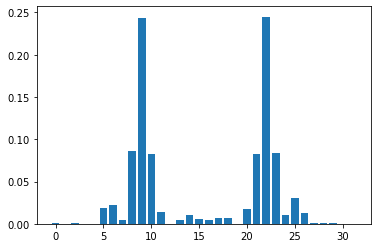

In [9]:
plot_bar_graph(x,y)

Given Graph with Edges:<br>
Edge(0, 1, 5), Edge(0, 2, 1), Edge(1, 2, 7), Edge(1, 3, 4), Edge(2, 3, 2), Edge(3, 4, 3)<br>
<br>
The optimal solution to Maxcut for the given Graph can be obtained by dividing the nodes in two groups using bits 0 and 1 as:<br>
0 1 2 3 4 <- nodes<br>
0 1 0 0 1 <- bitstring i.e |9><br><br>
    OR<br><br>
0 1 2 3 4 <- nodes<br>
1 0 1 1 0 <- bitstring i.e |22><br>
<br>
The plot has highest probabilities for the state |22> and |9>, exactly the result that was expected

### Results for simpler cases:
Graph with three edges

#### Initializing the circuit

In [10]:
# Defines the list of qubits

num = 3
depth = 4
rep = 1000
qubits = [cirq.GridQubit(0, i) for i in range(0, num)]


# Defines the initialization

def initialization(qubits):
    for i in qubits:
        yield cirq.H.on(i)

#### Case 1:

{('0', '1'): Text(-0.22487421686616577, -0.4290849027012502, '5'),
 ('0', '2'): Text(0.14106059366597054, -0.07091509729874995, '1'),
 ('1', '2'): Text(0.08381362320019523, 0.4999999999999998, '7')}

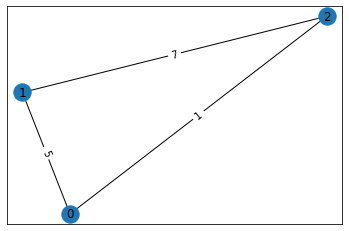

In [11]:
set_edges = [Edge(0, 1, 5), Edge(0, 2, 1), Edge(1, 2, 7)]

G = nx.Graph()

for z in set_edges:
    G.add_edge(str(z.start_node), str(z.end_node), weight = z.edge_weight)


pos=nx.spring_layout(G) 
nx.draw_networkx(G,pos)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

In [12]:
x, y = optimize()

     fun: -10.896
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 92
  status: 1
 success: True
       x: array([ 2.2858717 ,  0.72818709,  2.28694754,  2.64599939, -1.36981331,
        1.69884702,  0.6982698 , -0.23840571])
[2, 3, 5, 6, 1, 4, 0, 7]
[0.399, 0.048, 0.411, 0.041, 0.043, 0.053, 0.004, 0.001]


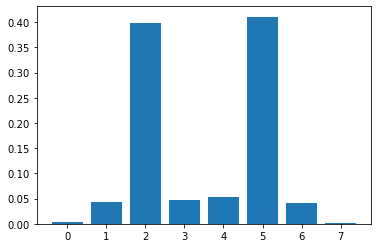

In [13]:
plot_bar_graph(x,y)

For case 1, the graph with Edges:
Edge(0, 1, 5), Edge(0, 2, 1), Edge(1, 2, 7)<br>
<br>
The nodes are divided in two groups using bits 0 and 1 to obtain the optimal Maxcut solution as:<br>
0 1 2 <- nodes<br>
0 1 0 <- bitstring i.e |2><br><br>
    OR<br><br>
0 1 2 <- nodes<br>
1 0 1 <- bitstring i.e |5><br>
<br>
The plot has highest probabilities for the state |5> and |2> which is exactly the expected result


#### Case 2:

{('0', '1'): Text(0.19071633671635674, -0.5000000000000003, '5'),
 ('0', '2'): Text(-0.34468403821178945, 0.4406201191062831, '7'),
 ('1', '2'): Text(0.1539677014954327, 0.05937988089371654, '1')}

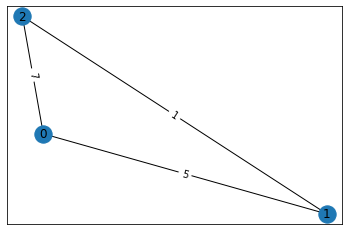

In [14]:
set_edges = [Edge(0, 1, 5), Edge(0, 2, 7), Edge(1, 2, 1)]

G = nx.Graph()

for z in set_edges:
    G.add_edge(str(z.start_node), str(z.end_node), weight = z.edge_weight)


pos=nx.spring_layout(G) 
nx.draw_networkx(G,pos)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

In [15]:
x, y = optimize()

     fun: -11.72
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 98
  status: 1
 success: True
       x: array([-1.48092763, -2.02496172, -1.78694049,  0.57798481,  2.92276951,
       -0.97717288, -2.01339914, -1.5332155 ])
[4, 3, 1, 5, 2, 6, 7, 0]
[0.455, 0.505, 0.008, 0.007, 0.007, 0.009, 0.005, 0.004]


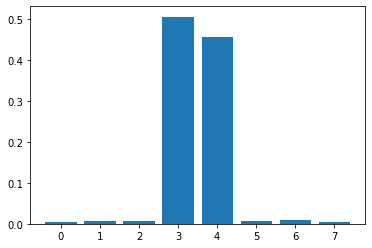

In [16]:
plot_bar_graph(x,y)

For case 2, the graph with Edges:
Edge(0, 1, 5), Edge(0, 2, 7), Edge(1, 2, 1)<br>
<br>
To obtain the optimal solution, the nodes should be seperated in two groups as follows:<br>
0 1 2 <- nodes<br>
0 1 1 <- bitstring i.e |3><br><br>
    OR<br><br>
0 1 2 <- nodes<br>
1 0 0 <- bitstring i.e |4><br>
<br>
The plot has highest probabilities for the expected result state |3> and |4>.<br>

### Case for which the output result does not match with expected optimal solution:

In [21]:
# Defines the list of qubits

num = 5
depth = 4
rep = 1000
qubits = [cirq.GridQubit(0, i) for i in range(0, num)]


# Defines the initialization

def initialization(qubits):
    for i in qubits:
        yield cirq.H.on(i)

{('0', '1'): Text(0.09377675979473014, 0.6313276336972151, '5'),
 ('0', '2'): Text(0.1845993415068361, 0.45696757601032223, '1'),
 ('1', '2'): Text(0.10506911368116945, 0.2008513559597735, '7'),
 ('1', '3'): Text(-0.027468331267113438, 0.04303242398967774, '4'),
 ('2', '3'): Text(0.06335425044499252, -0.13132763369721515, '10'),
 ('3', '4'): Text(-0.1917226074913678, -0.6445732828336554, '3')}

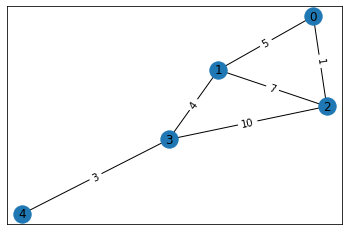

In [22]:
set_edges = [Edge(0, 1, 5), Edge(0, 2, 1), Edge(1, 2, 7), Edge(1, 3, 4), Edge(2, 3, 10), Edge(3, 4, 3)]

G = nx.Graph()

for z in set_edges:
    G.add_edge(str(z.start_node), str(z.end_node), weight = z.edge_weight)


pos=nx.spring_layout(G) 
nx.draw_networkx(G,pos)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

In [23]:
x, y = optimize()

     fun: -18.957
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 93
  status: 1
 success: True
       x: array([-0.50379945,  0.26035153,  4.78027078, -0.86104134, -0.41658346,
        1.82204337, -0.96888879, -1.941295  ])
[19, 14, 18, 22, 24, 9, 31, 7, 29, 16, 13, 10, 8, 11, 28, 12, 2, 21, 23, 0, 6, 25, 20, 15, 17, 30, 3, 5, 26, 4, 1]
[0.026, 0.021, 0.116, 0.09, 0.021, 0.1, 0.009, 0.017, 0.013, 0.015, 0.107, 0.09, 0.078, 0.018, 0.013, 0.034, 0.013, 0.071, 0.066, 0.003, 0.004, 0.004, 0.02, 0.011, 0.019, 0.001, 0.009, 0.004, 0.001, 0.005, 0.001]


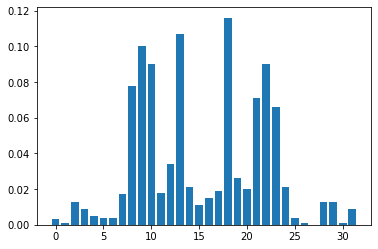

In [24]:
plot_bar_graph(x,y)

Expected optimal solution for this case is |21> and |10> but the plot results are not as expected

### Conclusion:
1. QAOA can solve combinatorial optimization problems.
2. If the optimization function get stuck in some local minimum, we get an unexpected plot.
3. Nodes are seperated in alternate fashion so the perfect solution may not be possible for complex graphs. 